# ORF recognition by Convolutional/Recurrent

Based on ORF_CNN_118 but model is now CNN+LSTM. Specifically 2x16 CNN and 2x16 LSTM and 1x16 Dense. Use a much larger training set and many more epochs. Achieve 96% accuracy.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 15:39:43 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=36            # how long is each sequence
CDS_LEN=18            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
import random
def partition_random_sequences(goal_per_class):
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        between_bases = random.randint(0,RNA_LEN-6) 
        utr5_bases = (RNA_LEN - (between_bases + 6)) // 2
        utr3_bases = RNA_LEN - (utr5_bases + (between_bases+6))
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        if len(one_seq) != RNA_LEN:
            print("WRONG LENGTH:",len(one_seq),utr5_bases,between_bases,utr3_bases)
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 48 trials to reach 10 per class.
It took 92245 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 36.0
Average ORF length: 20.055818181818182
NC seqs
Average RNA length: 36.0
Average ORF length: 1.9825454545454546


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (36, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 18, 16)            2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)         

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 27s 7ms/step - loss: 0.7074 - accuracy: 0.5149 - val_loss: 0.6415 - val_accuracy: 0.6198


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6375 - accuracy: 0.6232 - val_loss: 0.6143 - val_accuracy: 0.6426


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6189 - accuracy: 0.6346 - val_loss: 0.5972 - val_accuracy: 0.6465


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6001 - accuracy: 0.6503 - val_loss: 0.5848 - val_accuracy: 0.6799


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5861 - accuracy: 0.6811 - val_loss: 0.5651 - val_accuracy: 0.7008


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5710 - accuracy: 0.6970 - val_loss: 0.5570 - val_accuracy: 0.7010


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5628 - accuracy: 0.7032 - val_loss: 0.5380 - val_accuracy: 0.7131


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5479 - accuracy: 0.7100 - val_loss: 0.5312 - val_accuracy: 0.7180


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5390 - accuracy: 0.7183 - val_loss: 0.5300 - val_accuracy: 0.7178
Epoch 10/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5280 - accuracy: 0.7256 - val_loss: 0.5171 - val_accuracy: 0.7350


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5172 - accuracy: 0.7339 - val_loss: 0.4923 - val_accuracy: 0.7526


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4983 - accuracy: 0.7531 - val_loss: 0.4691 - val_accuracy: 0.7653


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4818 - accuracy: 0.7649 - val_loss: 0.4504 - val_accuracy: 0.7779


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4591 - accuracy: 0.7808 - val_loss: 0.4323 - val_accuracy: 0.7919


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4343 - accuracy: 0.7965 - val_loss: 0.4066 - val_accuracy: 0.8124


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4163 - accuracy: 0.8119 - val_loss: 0.3868 - val_accuracy: 0.8218


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3940 - accuracy: 0.8231 - val_loss: 0.3736 - val_accuracy: 0.8312


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3706 - accuracy: 0.8369 - val_loss: 0.3555 - val_accuracy: 0.8401


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3638 - accuracy: 0.8367 - val_loss: 0.3451 - val_accuracy: 0.8456


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.3469 - accuracy: 0.8442 - val_loss: 0.3201 - val_accuracy: 0.8563


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3279 - accuracy: 0.8554 - val_loss: 0.3148 - val_accuracy: 0.8592


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3172 - accuracy: 0.8625 - val_loss: 0.3071 - val_accuracy: 0.8651


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3060 - accuracy: 0.8671 - val_loss: 0.3082 - val_accuracy: 0.8667


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2941 - accuracy: 0.8726 - val_loss: 0.2826 - val_accuracy: 0.8763


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2803 - accuracy: 0.8797 - val_loss: 0.2706 - val_accuracy: 0.8800


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2706 - accuracy: 0.8856 - val_loss: 0.2555 - val_accuracy: 0.8861


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2569 - accuracy: 0.8897 - val_loss: 0.2373 - val_accuracy: 0.8966


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2377 - accuracy: 0.9012 - val_loss: 0.2520 - val_accuracy: 0.8935
Epoch 29/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2259 - accuracy: 0.9053 - val_loss: 0.2195 - val_accuracy: 0.9048


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2163 - accuracy: 0.9107 - val_loss: 0.2149 - val_accuracy: 0.9077


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2038 - accuracy: 0.9161 - val_loss: 0.1982 - val_accuracy: 0.9183


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1887 - accuracy: 0.9228 - val_loss: 0.2057 - val_accuracy: 0.9122
Epoch 33/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1806 - accuracy: 0.9266 - val_loss: 0.1825 - val_accuracy: 0.9229


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1749 - accuracy: 0.9282 - val_loss: 0.1701 - val_accuracy: 0.9293


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1575 - accuracy: 0.9360 - val_loss: 0.1677 - val_accuracy: 0.9284
Epoch 36/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1587 - accuracy: 0.9347 - val_loss: 0.1604 - val_accuracy: 0.9344


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1551 - accuracy: 0.9369 - val_loss: 0.1580 - val_accuracy: 0.9364


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1426 - accuracy: 0.9413 - val_loss: 0.1531 - val_accuracy: 0.9384


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1397 - accuracy: 0.9453 - val_loss: 0.1523 - val_accuracy: 0.9387


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1317 - accuracy: 0.9467 - val_loss: 0.1498 - val_accuracy: 0.9419


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1295 - accuracy: 0.9478 - val_loss: 0.1439 - val_accuracy: 0.9451


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 42/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1288 - accuracy: 0.9497 - val_loss: 0.1425 - val_accuracy: 0.9454


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1218 - accuracy: 0.9514 - val_loss: 0.1458 - val_accuracy: 0.9427
Epoch 44/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1138 - accuracy: 0.9542 - val_loss: 0.1344 - val_accuracy: 0.9486


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1093 - accuracy: 0.9563 - val_loss: 0.1301 - val_accuracy: 0.9498


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0983 - accuracy: 0.9607 - val_loss: 0.1313 - val_accuracy: 0.9496
Epoch 47/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1036 - accuracy: 0.9587 - val_loss: 0.1274 - val_accuracy: 0.9524


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0981 - accuracy: 0.9612 - val_loss: 0.1296 - val_accuracy: 0.9535


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0958 - accuracy: 0.9619 - val_loss: 0.1218 - val_accuracy: 0.9531
Epoch 50/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0931 - accuracy: 0.9635 - val_loss: 0.1391 - val_accuracy: 0.9514
Fold 1, 50 epochs, 818 sec


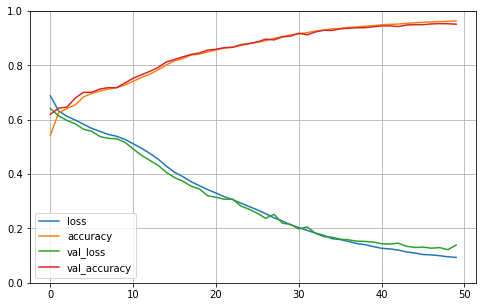

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 13s 8ms/step - loss: 0.7077 - accuracy: 0.5146 - val_loss: 0.6687 - val_accuracy: 0.5963
Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6569 - accuracy: 0.6046 - val_loss: 0.6188 - val_accuracy: 0.6330
Epoch 3/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6095 - accuracy: 0.6496 - val_loss: 0.5818 - val_accuracy: 0.6655
Epoch 4/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5806 - accuracy: 0.6707 - val_loss: 0.5553 - val_accuracy: 0.6897
Epoch 5/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5483 - accuracy: 0.6989 - val_loss: 0.5325 - val_accuracy: 0.7151
Epoch 6/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5178 - accuracy: 0.7198 - val_loss: 0.4791 - val_accuracy: 0.7436
Epoch 7/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4808 - accuracy: 

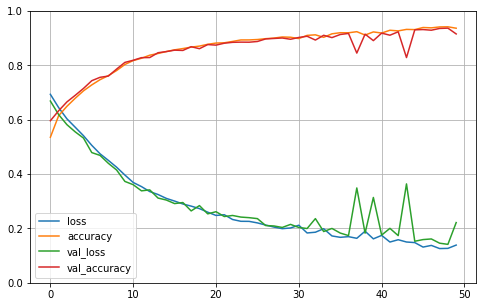

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 13s 8ms/step - loss: 0.7029 - accuracy: 0.5011 - val_loss: 0.6631 - val_accuracy: 0.5992
Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6567 - accuracy: 0.6084 - val_loss: 0.6273 - val_accuracy: 0.6268
Epoch 3/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6272 - accuracy: 0.6311 - val_loss: 0.6132 - val_accuracy: 0.6471
Epoch 4/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6056 - accuracy: 0.6509 - val_loss: 0.5812 - val_accuracy: 0.6683
Epoch 5/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5765 - accuracy: 0.6763 - val_loss: 0.5501 - val_accuracy: 0.6979
Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5396 - accuracy: 0.7111 - val_loss: 0.4857 - val_accuracy: 0.7437
Epoch 7/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4844 - accuracy:

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1027 - accuracy: 0.9556 - val_loss: 0.0979 - val_accuracy: 0.9559


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0881 - accuracy: 0.9592 - val_loss: 0.1022 - val_accuracy: 0.9550
Epoch 41/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1165 - accuracy: 0.9517 - val_loss: 0.1038 - val_accuracy: 0.9544
Epoch 42/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0915 - accuracy: 0.9599 - val_loss: 0.0960 - val_accuracy: 0.9578


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0821 - accuracy: 0.9627 - val_loss: 0.0958 - val_accuracy: 0.9569
Epoch 44/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0824 - accuracy: 0.9628 - val_loss: 0.1029 - val_accuracy: 0.9565
Epoch 45/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0815 - accuracy: 0.9628 - val_loss: 0.0908 - val_accuracy: 0.9610


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0783 - accuracy: 0.9644 - val_loss: 0.0919 - val_accuracy: 0.9604
Epoch 47/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0793 - accuracy: 0.9640 - val_loss: 0.1330 - val_accuracy: 0.9476
Epoch 48/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0768 - accuracy: 0.9651 - val_loss: 0.0861 - val_accuracy: 0.9616


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0773 - accuracy: 0.9658 - val_loss: 0.1011 - val_accuracy: 0.9590
Epoch 50/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.0721 - accuracy: 0.9675 - val_loss: 0.0926 - val_accuracy: 0.9604
Fold 3, 50 epochs, 564 sec


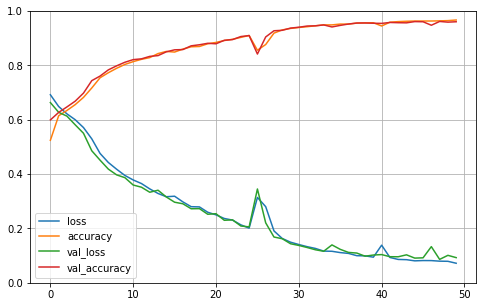

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 95.95%


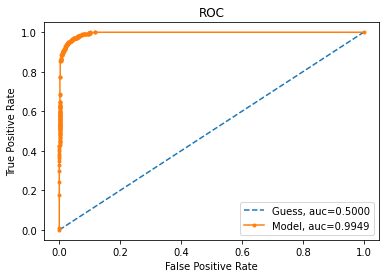

AUC: 99.49%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 16:10:58 UTC'